In [1]:
import sys 
import os

# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, Trainer, TWAP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [145]:
env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=True, Volume=False)

In [146]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [147]:
trainer = Trainer(agent, env, capacity=10000)

In [148]:
trainer.fill_exp_replay(max_steps=1000)

/Users/g0bel1n/DDQL-optimal-execution/ddql_optimal_execution/trainer/_trainer.py:77: MaxStepsTooLowWarning: Max steps is too low. It is set to 10000.
  )
Filling experience replay buffer: 10001it [00:47, 211.43it/s]                           


In [149]:
trainer.pretrain(max_steps=1000, batch_size=32)

Pretraining agent:   2%|▏         | 18/1000 [00:00<00:36, 27.26it/s]

Target network updated at step 15 with greediness 0.46


Pretraining agent:   3%|▎         | 34/1000 [00:01<00:33, 28.75it/s]

Target network updated at step 30 with greediness 0.21


Pretraining agent:   5%|▍         | 49/1000 [00:01<00:33, 28.52it/s]

Target network updated at step 45 with greediness 0.10


Pretraining agent:   6%|▋         | 65/1000 [00:02<00:32, 29.21it/s]

Target network updated at step 60 with greediness 0.05


Pretraining agent:   8%|▊         | 78/1000 [00:02<00:31, 28.87it/s]

Target network updated at step 75 with greediness 0.02


Pretraining agent:   9%|▉         | 93/1000 [00:03<00:37, 24.24it/s]

Target network updated at step 90 with greediness 0.01


Pretraining agent:  11%|█         | 108/1000 [00:03<00:32, 27.31it/s]

Target network updated at step 105 with greediness 0.01


Pretraining agent:  12%|█▏        | 123/1000 [00:04<00:30, 28.52it/s]

Target network updated at step 120 with greediness 0.01


Pretraining agent:  14%|█▍        | 138/1000 [00:04<00:30, 28.45it/s]

Target network updated at step 135 with greediness 0.01


Pretraining agent:  15%|█▌        | 154/1000 [00:05<00:29, 29.15it/s]

Target network updated at step 150 with greediness 0.01


Pretraining agent:  17%|█▋        | 170/1000 [00:06<00:28, 29.26it/s]

Target network updated at step 165 with greediness 0.01


Pretraining agent:  18%|█▊        | 185/1000 [00:06<00:29, 27.91it/s]

Target network updated at step 180 with greediness 0.01


Pretraining agent:  20%|█▉        | 198/1000 [00:07<00:28, 28.62it/s]

Target network updated at step 195 with greediness 0.01


Pretraining agent:  21%|██▏       | 213/1000 [00:07<00:27, 28.43it/s]

Target network updated at step 210 with greediness 0.01


Pretraining agent:  23%|██▎       | 228/1000 [00:08<00:27, 27.74it/s]

Target network updated at step 225 with greediness 0.01


Pretraining agent:  24%|██▍       | 243/1000 [00:08<00:26, 28.30it/s]

Target network updated at step 240 with greediness 0.01


Pretraining agent:  26%|██▌       | 258/1000 [00:09<00:26, 28.10it/s]

Target network updated at step 255 with greediness 0.01


Pretraining agent:  27%|██▋       | 273/1000 [00:09<00:26, 27.95it/s]

Target network updated at step 270 with greediness 0.01


Pretraining agent:  29%|██▉       | 289/1000 [00:10<00:24, 29.33it/s]

Target network updated at step 285 with greediness 0.01


Pretraining agent:  30%|███       | 304/1000 [00:10<00:27, 25.42it/s]

Target network updated at step 300 with greediness 0.01


Pretraining agent:  32%|███▏      | 319/1000 [00:11<00:24, 27.49it/s]

Target network updated at step 315 with greediness 0.01


Pretraining agent:  33%|███▎      | 334/1000 [00:11<00:23, 28.53it/s]

Target network updated at step 330 with greediness 0.01


Pretraining agent:  35%|███▍      | 349/1000 [00:12<00:22, 29.27it/s]

Target network updated at step 345 with greediness 0.01


Pretraining agent:  36%|███▋      | 364/1000 [00:12<00:22, 28.12it/s]

Target network updated at step 360 with greediness 0.01


Pretraining agent:  38%|███▊      | 380/1000 [00:13<00:21, 28.41it/s]

Target network updated at step 375 with greediness 0.01


Pretraining agent:  39%|███▉      | 393/1000 [00:13<00:21, 28.68it/s]

Target network updated at step 390 with greediness 0.01


Pretraining agent:  41%|████      | 408/1000 [00:14<00:20, 28.63it/s]

Target network updated at step 405 with greediness 0.01


Pretraining agent:  42%|████▏     | 423/1000 [00:14<00:20, 28.49it/s]

Target network updated at step 420 with greediness 0.01


Pretraining agent:  44%|████▍     | 439/1000 [00:15<00:20, 27.61it/s]

Target network updated at step 435 with greediness 0.01


Pretraining agent:  45%|████▌     | 454/1000 [00:16<00:18, 28.87it/s]

Target network updated at step 450 with greediness 0.01


Pretraining agent:  47%|████▋     | 469/1000 [00:16<00:18, 28.44it/s]

Target network updated at step 465 with greediness 0.01


Pretraining agent:  48%|████▊     | 484/1000 [00:17<00:17, 29.32it/s]

Target network updated at step 480 with greediness 0.01


Pretraining agent:  50%|█████     | 500/1000 [00:17<00:17, 27.86it/s]

Target network updated at step 495 with greediness 0.01


Pretraining agent:  52%|█████▏    | 515/1000 [00:18<00:17, 28.34it/s]

Target network updated at step 510 with greediness 0.01


Pretraining agent:  53%|█████▎    | 528/1000 [00:18<00:16, 29.41it/s]

Target network updated at step 525 with greediness 0.01


Pretraining agent:  54%|█████▍    | 543/1000 [00:19<00:16, 28.34it/s]

Target network updated at step 540 with greediness 0.01


Pretraining agent:  56%|█████▌    | 559/1000 [00:19<00:15, 28.32it/s]

Target network updated at step 555 with greediness 0.01


Pretraining agent:  57%|█████▋    | 574/1000 [00:20<00:15, 27.69it/s]

Target network updated at step 570 with greediness 0.01


Pretraining agent:  59%|█████▉    | 589/1000 [00:20<00:14, 28.59it/s]

Target network updated at step 585 with greediness 0.01


Pretraining agent:  60%|██████    | 604/1000 [00:21<00:14, 28.23it/s]

Target network updated at step 600 with greediness 0.01


Pretraining agent:  62%|██████▏   | 619/1000 [00:21<00:13, 27.88it/s]

Target network updated at step 615 with greediness 0.01


Pretraining agent:  63%|██████▎   | 634/1000 [00:22<00:12, 28.34it/s]

Target network updated at step 630 with greediness 0.01


Pretraining agent:  65%|██████▍   | 649/1000 [00:22<00:12, 28.66it/s]

Target network updated at step 645 with greediness 0.01


Pretraining agent:  66%|██████▋   | 664/1000 [00:23<00:11, 28.81it/s]

Target network updated at step 660 with greediness 0.01


Pretraining agent:  68%|██████▊   | 680/1000 [00:24<00:11, 28.81it/s]

Target network updated at step 675 with greediness 0.01


Pretraining agent:  70%|██████▉   | 695/1000 [00:24<00:11, 27.35it/s]

Target network updated at step 690 with greediness 0.01


Pretraining agent:  71%|███████   | 710/1000 [00:25<00:10, 28.08it/s]

Target network updated at step 705 with greediness 0.01


Pretraining agent:  72%|███████▎  | 725/1000 [00:25<00:09, 27.92it/s]

Target network updated at step 720 with greediness 0.01


Pretraining agent:  74%|███████▍  | 740/1000 [00:26<00:09, 28.48it/s]

Target network updated at step 735 with greediness 0.01


Pretraining agent:  75%|███████▌  | 753/1000 [00:26<00:08, 28.07it/s]

Target network updated at step 750 with greediness 0.01


Pretraining agent:  77%|███████▋  | 768/1000 [00:27<00:08, 27.60it/s]

Target network updated at step 765 with greediness 0.01


Pretraining agent:  78%|███████▊  | 784/1000 [00:27<00:08, 26.55it/s]

Target network updated at step 780 with greediness 0.01


Pretraining agent:  80%|████████  | 800/1000 [00:28<00:07, 28.35it/s]

Target network updated at step 795 with greediness 0.01


Pretraining agent:  82%|████████▏ | 815/1000 [00:28<00:06, 28.48it/s]

Target network updated at step 810 with greediness 0.01


Pretraining agent:  83%|████████▎ | 828/1000 [00:29<00:06, 26.84it/s]

Target network updated at step 825 with greediness 0.01


Pretraining agent:  84%|████████▍ | 844/1000 [00:30<00:05, 28.23it/s]

Target network updated at step 840 with greediness 0.01


Pretraining agent:  86%|████████▌ | 859/1000 [00:30<00:04, 28.75it/s]

Target network updated at step 855 with greediness 0.01


Pretraining agent:  87%|████████▋ | 874/1000 [00:31<00:04, 28.20it/s]

Target network updated at step 870 with greediness 0.01


Pretraining agent:  89%|████████▉ | 889/1000 [00:31<00:03, 29.17it/s]

Target network updated at step 885 with greediness 0.01


Pretraining agent:  90%|█████████ | 905/1000 [00:32<00:03, 29.05it/s]

Target network updated at step 900 with greediness 0.01


Pretraining agent:  92%|█████████▏| 919/1000 [00:32<00:02, 29.74it/s]

Target network updated at step 915 with greediness 0.01


Pretraining agent:  93%|█████████▎| 934/1000 [00:33<00:02, 29.36it/s]

Target network updated at step 930 with greediness 0.01


Pretraining agent:  95%|█████████▌| 950/1000 [00:33<00:01, 28.84it/s]

Target network updated at step 945 with greediness 0.01


Pretraining agent:  96%|█████████▌| 962/1000 [00:34<00:01, 28.86it/s]

Target network updated at step 960 with greediness 0.01


Pretraining agent:  98%|█████████▊| 978/1000 [00:34<00:00, 29.16it/s]

Target network updated at step 975 with greediness 0.01


Pretraining agent:  99%|█████████▉| 993/1000 [00:35<00:00, 26.92it/s]

Target network updated at step 990 with greediness 0.01


Pretraining agent: 100%|██████████| 1000/1000 [00:35<00:00, 28.12it/s]


In [150]:
trainer.train(max_steps=10000, batch_size=128)

Training agent:   5%|▌         | 6/120 [00:00<00:20,  5.68it/s]

Target network updated at step 1005 with greediness 0.01


Training agent:  18%|█▊        | 21/120 [00:03<00:17,  5.54it/s]

Target network updated at step 1020 with greediness 0.01


Training agent:  31%|███       | 37/120 [00:06<00:14,  5.60it/s]

Target network updated at step 1035 with greediness 0.01


Training agent:  43%|████▎     | 52/120 [00:09<00:12,  5.32it/s]

Target network updated at step 1050 with greediness 0.01


Training agent:  56%|█████▌    | 67/120 [00:12<00:09,  5.65it/s]

Target network updated at step 1065 with greediness 0.01


Training agent:  68%|██████▊   | 82/120 [00:14<00:06,  5.66it/s]

Target network updated at step 1080 with greediness 0.01


Training agent:  81%|████████  | 97/120 [00:17<00:04,  5.61it/s]

Target network updated at step 1095 with greediness 0.01


Training agent:  93%|█████████▎| 112/120 [00:20<00:01,  5.55it/s]

Target network updated at step 1110 with greediness 0.01


Training agent: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]


In [151]:
env.state

{'Price': -0.935039145725786,
 'Trend': -1.5763728606057315,
 'period': 4.0,
 'QV': -0.2576286478877492,
 'inventory': 47}

In [152]:
#test the agent
pnl= {'twap':[], 'ddql':[]}
env.reset()

twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)

pnl_twap = []
pnl_ddql = []

random_ep = np.random.choice(np.arange(len(env.historical_data_series)), 100)

for ep in random_ep:
    env.swap_episode(ep)
    _pnl_twap = [0]
    while not env.done:
        current_state = env.state.copy()
        action = twap(current_state)
        _ = env.step(action)
        _pnl_twap.append(env.state['Price']*action)
    pnl_twap.append(_pnl_twap)

    env.reset()
    _pnl_ddql = [0]
    while not env.done:
        current_state = env.state.copy()
        action = trainer.agent(current_state)
        _ = env.step(action)
        _pnl_ddql.append(env.state['Price']*action)
    pnl_ddql.append(_pnl_ddql)

In [153]:
pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)

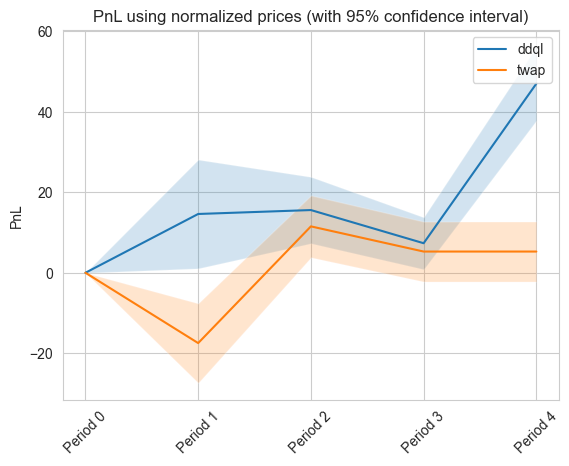

In [154]:
confidence_level = .95

plt.plot(pnl_ddql.mean(axis=0), label='ddql')
plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.2)
plt.plot(pnl_twap.mean(axis=0), label='twap')
plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.2)
plt.legend()
plt.xticks(
    rotation=45, ticks=range(5), labels=[f"Period {i}" for i in range(5)]
)

plt.title(r'PnL using normalized prices (with 95% confidence interval)')
plt.ylabel('PnL')
plt.show()

Text(0.5, 0, 'PnL')

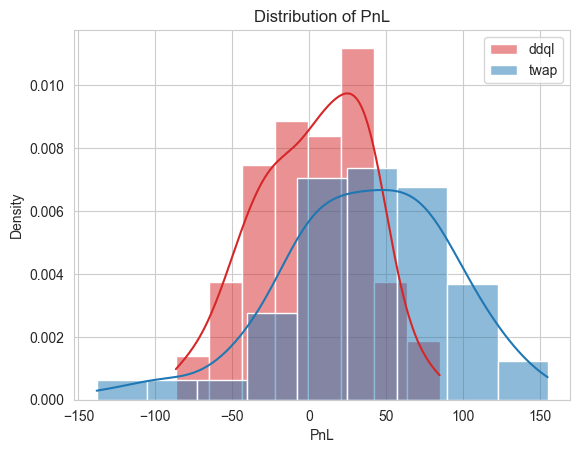

In [200]:
sns.histplot(pnl_twap.sum(axis=1), label='ddql', kde=True, stat='density', color='tab:red', alpha=.5)
sns.histplot(pnl_ddql.sum(axis=1), label='twap', kde=True, stat='density', color='tab:blue', alpha=.5)
plt.legend()
plt.title('Distribution of PnL')
plt.xlabel('PnL')

In [156]:
np.mean(pnl_twap.sum(axis=1))-np.mean(pnl_ddql.sum(axis=1))

-79.9967188603093

In [ ]:
grid = {
    "QV": [True, False],
    "Volume": [True, False],

}

data = dict()

for QV in grid["QV"]:
    for Volume in grid["Volume"]:
        env = MarketEnvironnement(initial_inventory=100, multi_episodes=True, QV=QV, Volume=Volume)
        agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)
        trainer = Trainer(agent, env, capacity=10000)
        trainer.fill_exp_replay(max_steps=10000)
        trainer.pretrain(max_steps=1000, batch_size=32)
        trainer.train(max_steps=10000, batch_size=128)
        env.reset()
        twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)
        pnl_twap = []
        pnl_ddql = []
        random_ep = np.random.choice(np.arange(len(env.historical_data_series)), 100)
        for ep in random_ep:
            env.swap_episode(ep)
            _pnl_twap = [0]
            while not env.done:
                current_state = env.state.copy()
                action = twap(current_state)
                _ = env.step(action)
                _pnl_twap.append(env.state['Price']*action)
            pnl_twap.append(_pnl_twap)
            env.reset()
            _pnl_ddql = [0]
            while not env.done:
                current_state = env.state.copy()
                action = trainer.agent(current_state)
                _ = env.step(action)
                _pnl_ddql.append(env.state['Price']*action)
            pnl_ddql.append(_pnl_ddql)

        pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)
        data[(QV, Volume)] = (pnl_ddql, pnl_twap)



In [159]:
import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [169]:
sns.set_palette('pastel')
sns.set_style('whitegrid')

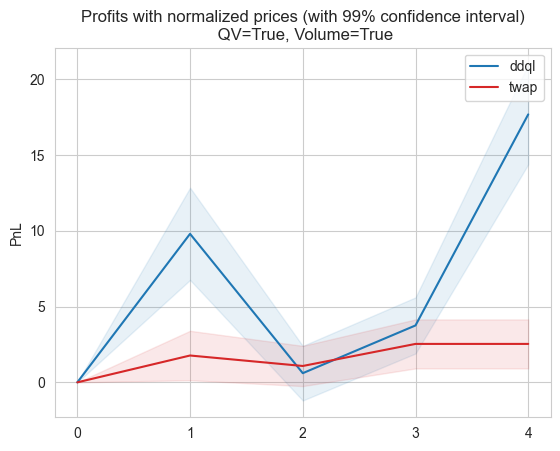

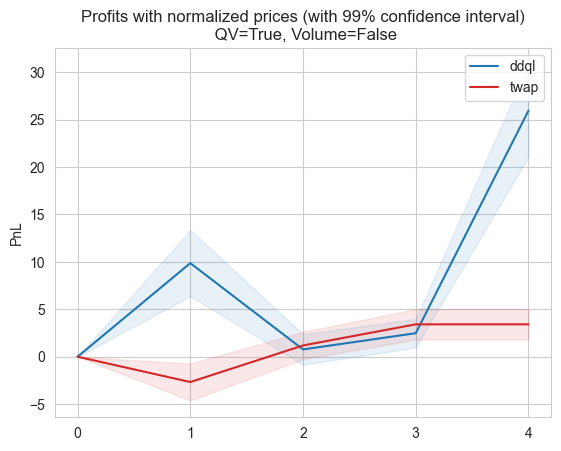

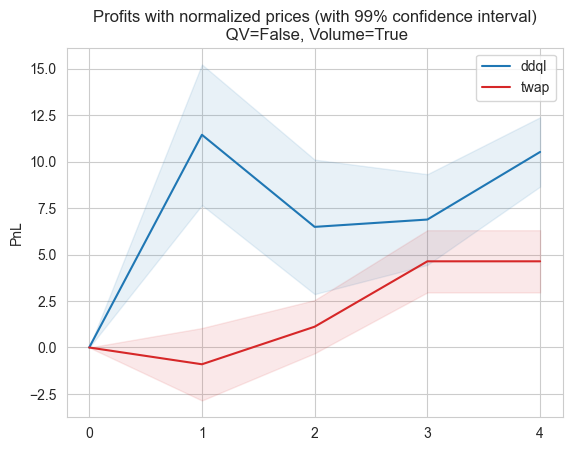

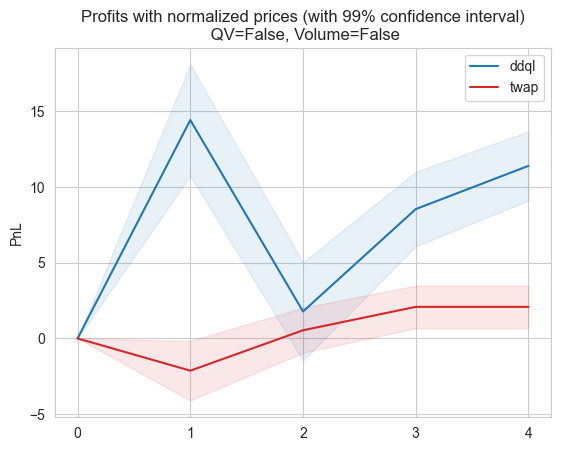

In [198]:
for i, (QV, Volume) in enumerate(data):
    pnl_ddql, pnl_twap = data[(QV, Volume)]
    
    confidence_level_2 = .99
    plt.plot(pnl_ddql.mean(axis=0), label='ddql', color='tab:blue')
    plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level_2*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level_2*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.1,   color='tab:blue')

    plt.plot(pnl_twap.mean(axis=0), label='twap', color='tab:red')
    plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.1, color='tab:red')
    plt.legend()
    plt.xticks(
        #rotation=45,
        ticks=range(5), labels=[f"{i}" for i in range(5)]
    )
    plt.title(f'Profits with normalized prices (with 99% confidence interval)\n QV={QV}, Volume={Volume}')
    
    plt.ylabel('PnL')
    plt.savefig(f'pnl_QV_{QV}_Volume_{Volume}.png')
    plt.show()

(True, True) 23.906450396826592


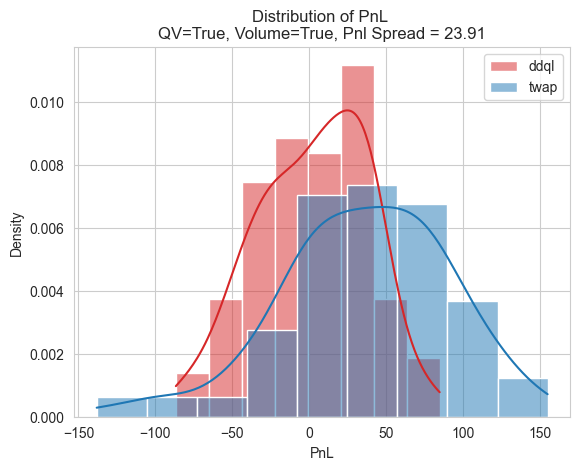

(True, False) 33.7180838651097


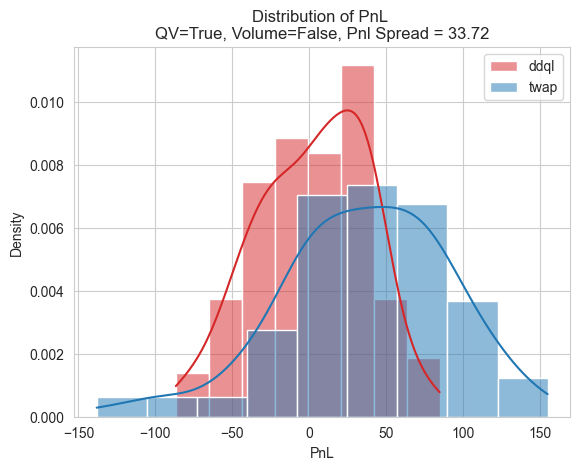

(False, True) 25.847956815623903


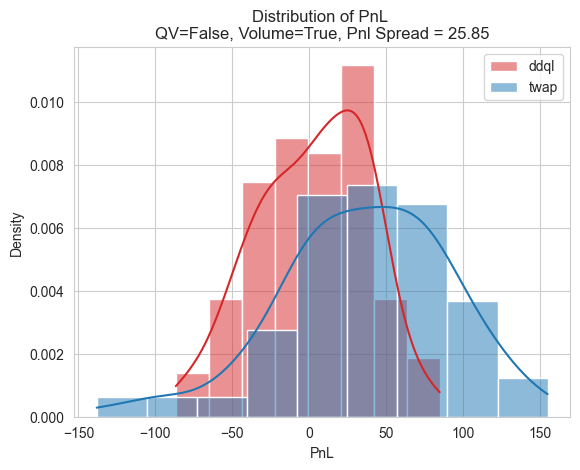

(False, False) 33.58937048445787


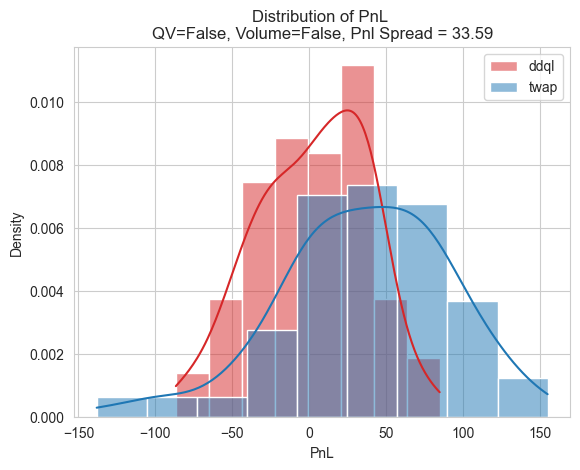

In [204]:
for key in data:
    print(key, np.mean(data[key][0].sum(axis=1))-np.mean(data[key][1].sum(axis=1)))
    #plt.hist(data[key][0].sum(axis=1), label='ddql', alpha=.5, color='tab:blue')
    #plt.axvline(np.mean(data[key][0].sum(axis=1)), color='tab:blue')
    #plt.hist(data[key][1].sum(axis=1), label='twap', alpha=.5, color='tab:red')
    #plt.axvline(np.mean(data[key][1].sum(axis=1)), color='tab:red')

    sns.histplot(pnl_twap.sum(axis=1), label='ddql', kde=True, stat='density', color='tab:red', alpha=.5)
    sns.histplot(pnl_ddql.sum(axis=1), label='twap', kde=True, stat='density', color='tab:blue', alpha=.5)
    #plt.legend()
    #plt.title('')
    plt.xlabel('PnL')

    plt.legend()
    plt.title(f'Distribution of PnL \nQV={key[0]}, Volume={key[1]}, Pnl Spread = {np.mean(data[key][0].sum(axis=1))-np.mean(data[key][1].sum(axis=1)):.2f}')
    plt.savefig(f'../figs/QV_{key[0]}_Volume_{key[1]}_hists.png')
    plt.show()


In [203]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")